In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint

In [2]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_stateology as TpM
import b_spin_ops as su2
import c_maxent_eom as gij

In [18]:
params={}
params['size'] = 6; params['chain_type']='XX'; params['temp']=10**-1

# Qubits
params['w'] = 1*np.pi

# Interaction
params['Jx'] = 10* 10**-1 * params['w']

# External driving
params['omega'] = 1.* np.pi; params['V0'] = 9*10**-2 *params['omega']; params['phase']=0
print(params['V0']/params['omega']<=.01)

False


In [19]:
spin_ops=su2.one_body_spin_ops(args=params)

H0 = .5 * params['w'] * sum(sz for sz in spin_ops['sz'])
Hint = 1. * su2.Heisenberg_1D_Hamiltonian(args=params,
                                                   spin_ops=spin_ops,
                                                   closed_bcs=True, visualization=False)
def Vt_driving(t, args):
    return args['V0'] * np.cos(args['omega']*t+args['phase'])

Vt_ops =  sum(sigmax for sigmax in spin_ops['sx'])

def Vt_ext(t,args):
    return Vt_driving(t=t,args=args) * Vt_ops

def Ht_func(t,args):
    return H0+Hint+Vt_ext(t=t,args=args)

H_mesolve=[H0+Hint, [Vt_ops, Vt_driving]]

Hrwa_cr_0=.5*(params['w'] - params['omega'])*sum(sz for sz in spin_ops['sz'])
Hrwa_cr_int=Hint

cr_sx_td= lambda t,params:np.cos(2*params['omega']*t+params['phase'])
cr_sy_td= lambda t,params:np.sin(-2*params['omega']*t+params['phase'])

Hrwa_cr_mesolve=[Hrwa_cr_0+Hrwa_cr_int, [5*params['V0']*sum(sx for sx in spin_ops['sx']),cr_sx_td], 
                                     [.5*params['V0']*sum(sy for sy in spin_ops['sy']), cr_sy_td] ]

Hrwa=Hrwa_cr_0+Hint
Hrwa+= .5*params['V0']*sum(np.cos(params['phase'])*sx + np.sin(params['phase'])*sy for sx,sy in zip(spin_ops['sx'],spin_ops['sy']))

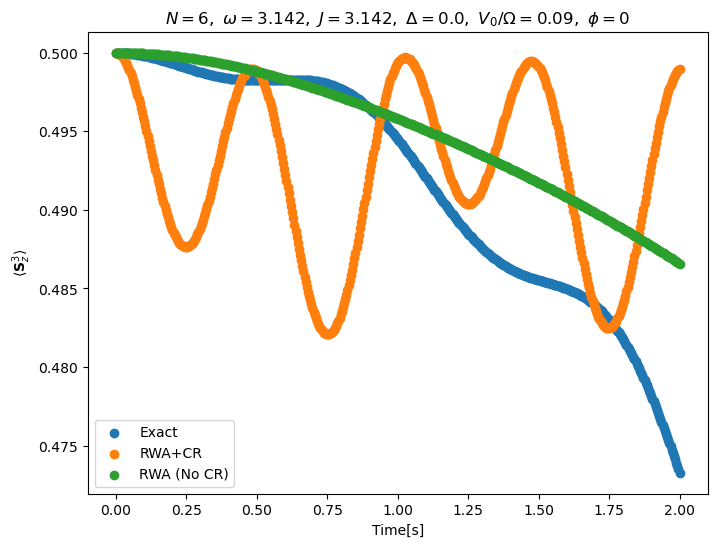

In [20]:
rho0=qutip.tensor([qutip.basis(2,0) for i in range(params['size'])])
timespans=np.linspace(0,2., 500)

resex=qutip.mesolve(H=H_mesolve, rho0=rho0, tlist=timespans, e_ops=spin_ops['sz'][3], args=params)
resrwa_cr=qutip.mesolve(H=Hrwa_cr_mesolve, rho0=rho0, tlist=timespans, e_ops=spin_ops['sz'][3], args=params)
resrwa_pure=qutip.mesolve(H=Hrwa, rho0=rho0, tlist=timespans, e_ops=spin_ops['sz'][3], args=params)

fig0,ax0=plt.subplots(figsize=(8,6))

plt.scatter(timespans, resex.expect[0], label='Exact')
plt.scatter(timespans, resrwa_cr.expect[0], label='RWA+CR')
plt.scatter(timespans, resrwa_pure.expect[0], label='RWA (No CR)')
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle {\bf S}_z^3 \rangle$")
plt.title(r'$N={},\,\, \omega={}, \,\, J={}, \,\, \Delta={},\,\, V_0/\Omega={}, \,\, \phi={}$'.format(
                                                                params['size'],
                                                                round(params['w'],3), 
                                                                round(params['Jx'],3), 
                                                                round(params['w']-params['omega'],3), 
                                                                round(params['V0']/params['omega'],3),
                                                                round(params['phase'],2)))
plt.show()

In [13]:
HBB0=[spin_ops['idop'], H0]
phi0=[.0, -5.]; beta=1/params['temp']
K0=-sum(phi*op for phi,op in zip(phi0, HBB0))
sigma0=TpM.safe_expm_and_normalize(K0)
phi0[0]=np.log(sigma0.tr())
K0=-sum(phi*op for phi,op in zip(phi0, HBB0))
sigma0=TpM.safe_expm_and_normalize(K0)

HBB0+=[K0]
timespans=np.linspace(0,20,160)

In [14]:
[qutip.expect(sigma0, szi) for szi in spin_ops['sz']]

[0.499611947439546,
 0.499611947439546,
 0.499611947439546,
 0.499611947439546,
 0.499611947439546,
 0.499611947439546]

In [15]:
def fetch_covar_scalar_product(sigma: Qobj):
    return lambda op1, op2: 0.5 * (sigma * (op1.dag() * op2 +
                                            op2 * op1.dag())).tr()

def gram_matrix(basis: list, sp: Callable):
    size = len(basis)
    result = np.zeros([size, size], dtype=float)

    for i, op1 in enumerate(basis):
        for j, op2 in enumerate(basis):
            if j < i:
                continue
            entry = np.real(sp(op1, op2))
            if i == j:
                result[i, i] = entry
            else:
                result[i, j] = result[j, i] = entry

    return result.round(14)

def orthogonalize_basis(basis: list, sp: Callable, idop: Qobj = None):
    if idop:
        idnorm_sq = sp(idop, idop)
        id_comp = [sp(idop, op) / idnorm_sq for op in basis]
        basis = ([idop * idnorm_sq**-0.5] +
                 [op - la for la, op in zip(id_comp, basis)])

    gs = gram_matrix(basis, sp)
    evals, evecs = np.linalg.eigh(gs)
    evecs = [vec / np.linalg.norm(vec) for vec in evecs.transpose()]
    return [
        p ** (-0.5) * sum(c * op for c, op in zip(w, basis))
        for p, w in zip(evals, evecs)
        if p > 0.00001
    ]

def build_HierarchicalBasis(generator: Qobj, seed_operator: Qobj, depth, tol = 1e-5, verbose = False):
    assert linalg.norm(seed_operator - seed_operator.dag()) < tol, "Error: Seed operator not Hermitian"
    hierarch_basis_local = [seed_operator]
    for i in range(1, depth):
        local_op = 1j * commutator(generator, hierarch_basis_local[i-1])
        assert linalg.norm(local_op - local_op.dag()) < tol, "Error: Iterated Commutator not Hermitian"
        norm = linalg.norm(local_op)
        if norm > tol:
            pass
        else: 
            local_op = None
            if verbose:
                print("     ###. HBasis terminated at step ", i)
        hierarch_basis_local.append(local_op)
        local_op = norm = None
    return hierarch_basis_local    

def project_op(op: Qobj, orthogonal_basis: list, sp: Callable):
    return np.array([sp(op2, op) for op2 in orthogonal_basis])

def commutator(op1,op2):
    return op1*op2-op2*op1

In [16]:
def projections(H,K0,basis0,timespan,args):
    print("**** Starting Simulation", datetime.now())
    results={}; results['covar_Kt']=[]; results['exact_Kt']=[];results['covar_sigmat']=[];results['exact_rhot']=[]
    res_exact = qutip.mesolve(H=H,
                              tlist=timespan,
                              rho0=K0,
                              args=args)
    rhot = [TpM.safe_expm_and_normalize(Kt) for Kt in res_exact.states]
    covar_sp=[fetch_covar_scalar_product(rho_at_timet) for rho_at_timet in rhot]
    timespan_prime=list(timespan)
    for t in timespan:
        ti = timespan_prime.index(t)
        if ti%40==0:
            print("-----Processing step",ti,"at time",datetime.now)
        orth_basis=orthogonalize_basis(basis=basis0,sp=covar_sp[ti],idop=basis0[0])
        phis_covar = project_op(res_exact.states[ti], orth_basis, covar_sp[ti])
        Kp_covar=sum(phi*op for phi,op in zip(phis_covar, orth_basis))
        sigma_covar=TpM.safe_expm_and_normalize(Kp_covar)
        results['covar_Kt'].append(Kp_covar)
        results['covar_sigmat'].append(sigma_covar)
    results['exact_Kt']=res_exact.states; results['exact_rhot']=rhot
    return results

In [17]:
def multiple_projections(H, K0, basis0, depths, timespan, args):
    
    res_sigmas=[]; res_Ks=[]
    for d in depths:
        hb_basis_d=build_HierarchicalBasis(generator=H,
                                           seed_operator=basis0[-1],
                                           depth=d)
        res_d=projections(H=H, 
                          K0=K0, 
                          basis0=hb_basis_d,
                          timespan=timespan,
                          args=args)
        res_sigmas.append(res_d['covar_sigmat']); res_Ks.append(res_d['covar_Kt'])
        res_d=None
    return res_sigmas, res_Ks

In [102]:
sigmas_maxent, Ks_maxent=multiple_projections(H=H_rwa, K0=K0,
                             basis0=HBB0,
                             depths=ds,
                             timespan=timespans,
                             args=params)

**** Starting Simulation 2024-03-13 15:32:42.219163
-----Processing step 0 at time <built-in method now of type object at 0x00007FFFA8C3C500>
-----Processing step 40 at time <built-in method now of type object at 0x00007FFFA8C3C500>
-----Processing step 80 at time <built-in method now of type object at 0x00007FFFA8C3C500>
-----Processing step 120 at time <built-in method now of type object at 0x00007FFFA8C3C500>
**** Starting Simulation 2024-03-13 15:32:45.857481
-----Processing step 0 at time <built-in method now of type object at 0x00007FFFA8C3C500>
-----Processing step 40 at time <built-in method now of type object at 0x00007FFFA8C3C500>
-----Processing step 80 at time <built-in method now of type object at 0x00007FFFA8C3C500>
-----Processing step 120 at time <built-in method now of type object at 0x00007FFFA8C3C500>
**** Starting Simulation 2024-03-13 15:32:53.767343
-----Processing step 0 at time <built-in method now of type object at 0x00007FFFA8C3C500>
-----Processing step 40 at

In [103]:
dist_rwa_exact=[linalg.norm(rwa-ex) for rwa,ex in zip(rhot_rwa, rhot_ex)]
dist_rwa_maxent=[[linalg.norm(rwa-sigma) for rwa,sigma in zip(rhot_rwa, covar_sigmat_list)] 
                 for covar_sigmat_list in sigmas_maxent ]

dist_exact_maxent=[[linalg.norm(ex-sigma) for ex,sigma in zip(rhot_ex, covar_sigmat_list)] 
                for covar_sigmat_list in sigmas_maxent ]

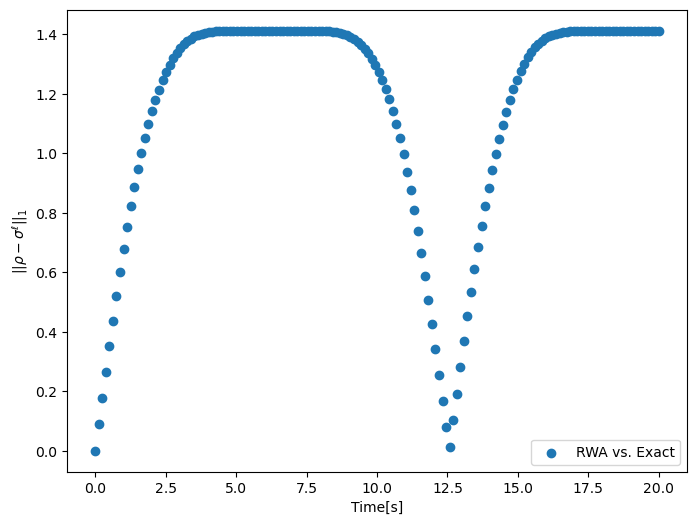

In [104]:
fig0,ax0=plt.subplots(figsize=(8, 6))

plt.scatter(timespans, dist_rwa_exact, label='RWA vs. Exact')

#for d in ds:
    #plt.scatter(timespans, dist_rwa_maxent[ds.index(d)], label='RWA d='+str(d))
    #plt.scatter(timespans, dist_exact_maxent[ds.index(d)], label='EX d='+str(d))
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r'$|| \rho - \sigma^\ell ||_{1}$')
plt.show()

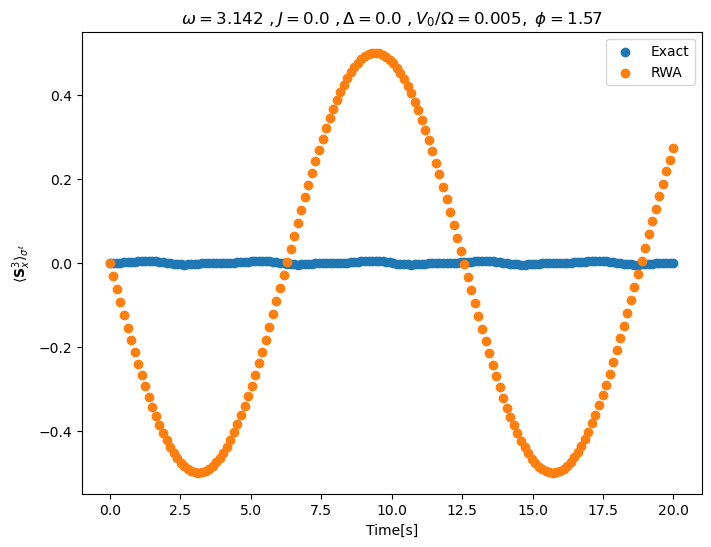

In [105]:
magnetization = sum(sz for sz in spin_ops['sz'])
sx3_ex=[qutip.expect(rho, spin_ops['sx'][2]) for rho in rhot_ex]
sx3_maxent=[[qutip.expect(sigma,spin_ops['sx'][2]) for sigma in covar_sigmat_list] for covar_sigmat_list in sigmas_maxent]
sx3_rwa=[qutip.expect(rho, spin_ops['sx'][2]) for rho in rhot_rwa]

fig0,ax0=plt.subplots(figsize=(8,6))

plt.scatter(timespans, sx3_ex, label='Exact')
plt.scatter(timespans, sx3_rwa, label='RWA')
#for d in ds: 
#    plt.scatter(timespans, sx3_maxent[ds.index(d)], label='d='+str(d))
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle {\bf S}_x^3 \rangle_{\sigma^\ell}$")
plt.title(r'$\omega={}\,\, , J={}\,\, , \Delta={}\,\, , V_0/\Omega={}, \,\, \phi={}$'.format(round(params['w'],3), 
                                                                round(params['Jx'],3), 
                                                                round(params['w']-params['omega'],3), 
                                                                params['V0']/params['omega'],
                                                                round(params['phase'],2)))
plt.show()

In [77]:
print(params)

{'size': 4, 'chain_type': 'XX', 'temp': 0.1, 'w': 3.141592653589793, 'Jx': 0.0, 'omega': 3.1400218572629983, 'V0': 0.015700109286314993, 'phase': 1.5707963267948966}


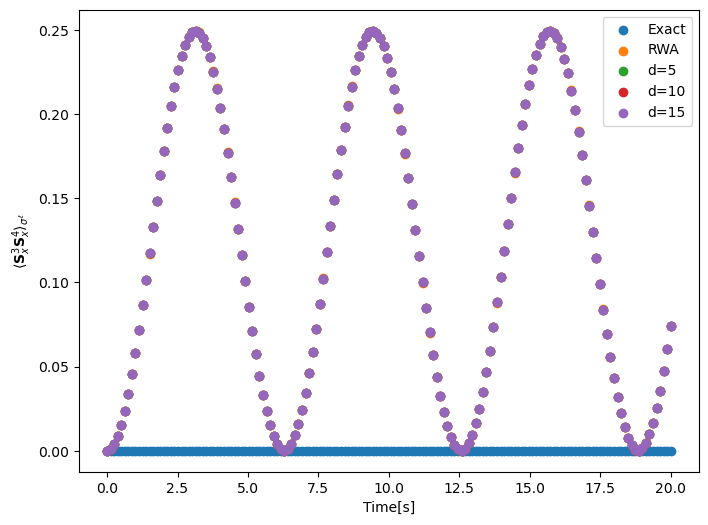

In [45]:
sx3sx4=spin_ops['sx'][0]*spin_ops['sx'][1]
sx3sx4_ex=[qutip.expect(rho, sx3sx4) for rho in rhot_ex]
sx3sx4_maxent=[[qutip.expect(sigma,sx3sx4) for sigma in covar_sigmat_list] for covar_sigmat_list in sigmas_maxent]
sx3sx4_rwa=[qutip.expect(rho, sx3sx4) for rho in rhot_rwa]

fig0,ax0=plt.subplots(figsize=(8,6))

plt.scatter(timespans, sx3sx4_ex, label='Exact')
plt.scatter(timespans, sx3sx4_rwa, label='RWA')
for d in ds: 
    plt.scatter(timespans, sx3sx4_maxent[ds.index(d)], label='d='+str(d))
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle {\bf S}_x^3 {\bf S}_x^4 \rangle_{\sigma^\ell}$")
plt.show()

In [ ]:
def fo

In [153]:
fmodes, fenergies = qutip.floquet_modes(H=H_mesolve, T=2*np.pi/params['Omega'], args=params)

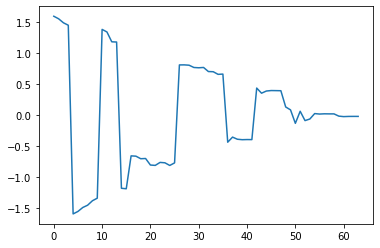

In [162]:
plt.plot(fenergies)

In [131]:
exact=qutip.mesolve(H=H_mesolve, 
                    rho0=sigma0,
                    tlist=timespans,
                    e_ops=[sx3sx4, spin_ops['sx'][2]],
                    args=params)

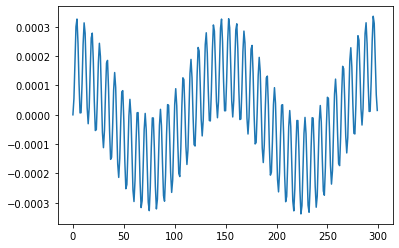

In [133]:
plt.plot(exact.expect[1])